In [1]:
from sympy import var,Function,Symbol,Rational
from ComputabilityGraphs.CMTVS import CMTVS
from bgc_md2.helper import bgc_md2_computers
from bgc_md2.resolve.mvars import (
    InFluxesBySymbol,
    OutFluxesBySymbol,
    InternalFluxesBySymbol,
    TimeSymbol,
    StateVariableTuple,
)

In [2]:
# obtain dictionary of symbols for equations from txt file
params_in = open(r"mini_model_sym_dict.txt", 'r')
sym_dict = {}
for line in params_in:
    k, v = line.strip().split('=')
    sym_dict[k.strip()] = v.strip()
    
params_in.close()

In [3]:
#define all the symbols you are going to use in the equations

for k in sym_dict.keys():
    code=k+" = Symbol('{0}')".format(k)
    exec(code)
    
func_dict = {
    "Gpp_grass": "Total C production for grass in g/m^2*month FIXME"
}
for k in func_dict.keys():
    code=k+" = Function('{0}')".format(k)
    exec(code)    
    
#I_wood=Function("I_wood") 
t=TimeSymbol("t") # the symbol used for time since it has a special role
e = Symbol("e")   # for exponential functions

agprod = prdx_1*f_stemp_ppdf_1*((avh2o_1 + (ppt_m * 0.1)) / pet)*biof*shdmod*sdlng
bgprod = agprod * rtsh
cprodc = (agprod + bgprod) * 0.4
cprodf = ((prdx_2*f_stemp_ppdf_2*((avh2o_2 + (ppt_m * 0.1)) / pet)*f_lait_laitop*0.5) - sumrsp)


# formulate the model
mvs = CMTVS(
    {
        StateVariableTuple( # the pool names in your preferred order
            (
                AGLIVC,
                BGLIVC,
                STDEDC,
                STRUCC_1,
                STRUCC_2,
                SOM1C_1,
                SOM1C_2,
                SOM2C,
                SOM3C,
                METABC_1,
                METABC_2,
                CROOTC,
                FBRCHC,
                FROOTC,
                RLEAVC,
                RLWODC,
                WOOD1C,
                WOOD2C,
                WOOD3C,
            )
        ), 
        t, 
        InFluxesBySymbol({   # trees.F, growth.F
                AGLIVC: cprodc * (agprod/(agprod + bgprod)),
                BGLIVC: cprodc * (1 - (agprod/(agprod + bgprod))),
                RLEAVC: cprodf * fcfrac_1_1,
                FROOTC: cprodf * fcfrac_2_1,
                FBRCHC: cprodf * fcfrac_3_1,
                RLWODC: cprodf * fcfrac_4_1,
                CROOTC: cprodf * fcfrac_5_1
        }),
        OutFluxesBySymbol({    # CO2 losses
            # woodec.F DECW* and WDLIG* values at cen_warmstart.F PLIGST(*)=3
            WOOD1C: ((decw1 * defac * (e**(-3*wdlig_3)) * Rational(45,100) * (1-wdlig_3)) + \
                    (decw1 * defac * (e**(-3*wdlig_3)) * Rational(3,10) * wdlig_3)) * WOOD1C,
            WOOD2C: ((decw2 * defac * (e**(-3*wdlig_4)) * Rational(45,100) * (1-wdlig_4)) + \
                    (decw2 * defac * (e**(-3*wdlig_4)) * Rational(3,10) * wdlig_4)) * WOOD2C,
            WOOD3C: ((decw3 * defac * (e**(-3*wdlig_5)) * Rational(45,100) * (1-wdlig_5)) + \
                    (decw3 * defac * (e**(-3*wdlig_5)) * Rational(3,10) * wdlig_5)) * WOOD3C,
            # litdec.F declig.F somdec.F strlig(*)=ligcon PLIGST(*)=3 anerb=1; dec* have defined values in .100 files
            STRUCC_1: ((dec1_1 * defac * (e**(-3*strlig_1)) * Rational(3,10) * strlig_1) + \
                      (dec1_1 * defac * (e**(-3*strlig_1)) * Rational(45,100) * (1-strlig_1))) * STRUCC_1,  
            STRUCC_2: ((dec1_2 * defac * (e**(-3*strlig_2)) * Rational(3,10) * strlig_2) +  \
                      (dec1_2 * defac * (e**(-3*strlig_2)) * Rational(55,100) * (1-strlig_2))) * STRUCC_2, 
            METABC_1: (dec2_1 * defac * Rational(55,100)) * METABC_1, 
            METABC_2: (dec2_2 * defac * Rational(55,100)) * METABC_2,  
            SOM1C_1: (dec3_1 * defac * Rational(6,10)) * SOM1C_1,
            # eftext=peftxa*peftxb*sand prelim.F ln 304 PEFTXA, PEFTXB at .100
            SOM1C_2: (dec3_2 * defac * eftext * p1co2_2) * SOM1C_2,
            SOM2C: (dec5 * defac * Rational(55,100)) * SOM2C,
            SOM3C: (dec4 * defac * Rational(55,100)) * SOM3C
        }),
        InternalFluxesBySymbol({
            (AGLIVC, STDEDC): (fsdeth_i * dthppt + fsdeth_s) * AGLIVC,
            # NOTA BENE: STDEDC and BGLIVC to metabolic and structural pools include the lignin to N ratio,
            # which includes the N:C ratio. bglivc_1 = BGLIVC and stdedc_1 = STDEDC; N:C ratio may
            # need its own matrix.
            (BGLIVC, METABC_2): rdr * (1 - (avh2o_1/(deck5 + avh2o_1))) * \
            (spl_I - spl_S * (((fligni1_2 + fligni2_2*arain) * 2.5) / (bglive_1/bglivc_1)) ) * BGLIVC,
            (BGLIVC, STRUCC_2):  rdr * (1 - (avh2o_1/(deck5 + avh2o_1))) * \
            (1 - (spl_I - spl_S * (((fligni1_2 + fligni2_2*arain) * 2.5) / (bglive_1/bglivc_1)))) * BGLIVC,
            (STDEDC, METABC_1): fallrt * (spl_I - spl_S * (((fligni1_1 + fligni2_1*arain) * 2.5) / \
                                                           (stdede_1/stdedc_1)) ) * STDEDC,
            (STDEDC, STRUCC_1): fallrt * (1 - (spl_I - spl_S * (((fligni1_1 + fligni2_1*arain) * 2.5) / \
                                                                (stdede_1/stdedc_1)))) * STDEDC,
            # (1) leaves (2) fine roots (3) fine branches (4) large wood (5) coarse roots
            # wdeath.F WOODDR*, LEAFDR values at cen_warmstart.F
            # for RLEAVC, leafdr_d_mo=1 for tave less than 13C.
            # NOTA BENE: RLEAVC and FROOTC to metabolic and structural pools include the lignin to N ratio,
            # which includes the N:C ratio. rleavc_1 = RLEAVC and frootc_1 = FROOTC; N:C ratio may 
            # need its own matrix. 
            (RLEAVC, METABC_1): (wooddr_1 * leafdr_d_mo + (1-wooddr_1) * leafdr_e_mo) * \
            (spl_I - spl_S * ((wdlig_1 * 2.5) / (0.55 * rleave_1/rleavc_1)) ) * RLEAVC,
            (RLEAVC, STRUCC_1): (wooddr_1 * leafdr_d_mo + (1-wooddr_1) * leafdr_e_mo) * \
            ( 1 - (spl_I - spl_S * ((wdlig_1 * 2.5) / (0.55 * rleave_1/rleavc_1)) )) * RLEAVC,
            (FROOTC, METABC_2): wooddr_2 * (spl_I - spl_S * ((wdlig_2 * 2.5) / (froote_1/frootc_1)) ) * FROOTC,
            (FROOTC, STRUCC_2): wooddr_2 * ( 1 - (spl_I - spl_S * ((wdlig_2 * 2.5) / (froote_1/frootc_1)))) * FROOTC,
            (FBRCHC, WOOD1C): wooddr_3 * FBRCHC,
            (RLWODC, WOOD2C): wooddr_4 * RLWODC,
            (CROOTC, WOOD3C): wooddr_5 * CROOTC,
            (WOOD1C, SOM1C_2): (decw1 * defac * (e**(-3*wdlig_3)) * Rational(55,100) * (1-wdlig_3)) * WOOD1C,
            (WOOD1C, SOM2C): (decw1 * defac * (e**(-3*wdlig_3)) * Rational(7,10) * wdlig_3) * WOOD1C,
            (WOOD2C, SOM1C_2): (decw2 * defac * (e**(-3*wdlig_4)) * Rational(55,100) * (1-wdlig_4)) * WOOD2C,
            (WOOD2C, SOM2C): (decw2 * defac * (e**(-3*wdlig_4)) * Rational(7,10) * wdlig_4) * WOOD2C,
            (WOOD3C, SOM1C_2): (decw3 * defac * (e**(-3*wdlig_5)) * Rational(55,100) * (1-wdlig_5)) * WOOD3C,
            (WOOD3C, SOM2C): (decw3 * defac * (e**(-3*wdlig_5)) * Rational(7,10) * wdlig_5) * WOOD3C,
            (STRUCC_1, SOM1C_1): (dec1_1 * defac * (e**(-3*strlig_1)) * Rational(55,100) * (1-strlig_1)) * STRUCC_1,
            (STRUCC_1, SOM2C): (dec1_1 * defac * (e**(-3*strlig_1)) * Rational(7,10) * strlig_1) * STRUCC_1, 
            (STRUCC_2, SOM1C_2): (dec1_2 * defac * (e**(-3*strlig_2)) * Rational(45,100) * (1-strlig_2)) * STRUCC_2,
            (STRUCC_2, SOM2C): (dec1_2 * defac * (e**(-3*strlig_2)) * Rational(7,10) * strlig_2) * STRUCC_2, 
            (METABC_1, SOM1C_1): (dec2_1 * defac * Rational(45,100)) * METABC_1, 
            (METABC_2, SOM1C_2): (dec2_2 * defac * Rational(45,100)) * METABC_2, 
            (SOM1C_1, SOM2C): (dec3_1 * defac * Rational(4,10)) * SOM1C_1, # P1CO2A(1)=0.6
            # p1co2_2=p1co2a_2+p1co2b_2*sand prelim.F ln 311 P1CO2A(2), P1CO2B(2) at *.100
            # fps1s3=ps1s3(1)+ps1s3(2)*clay prelim.F ln 315 PS1S3(1), PS1S3(2) at *.100
            # orglch=omlech(1)+omlech(2)*sand predec.F ln 106 OMLECH(1), OMLECH(2) at *.100
            # f_asmos2=min(1-((omlech(3)-amov(2))/omlech(3)), 1) OMLECH(3) at *.100 amov(2) at h2olos.F
            (SOM1C_2, SOM2C): (dec3_2 * defac * eftext * (1 - p1co2_2 - fps1s3 - (orglch*f_asmos2))) * SOM1C_2, 
            (SOM1C_2, SOM3C): (dec3_2 * defac * eftext * fps1s3) * SOM1C_2, 
            (SOM2C, SOM1C_2): (dec5 * defac * fps2s3) * SOM2C, 
            # fps2s3=ps2s3(1)+ps2s3(2)*clay prelim.F ln 316 PS2S3(1), PS2S3(2) at *.100
            (SOM2C, SOM3C): (dec5 * defac * (Rational(45,100) - fps2s3)) * SOM2C, 
            (SOM3C, SOM1C_2): (dec4 * defac * Rational(45,100)) * SOM3C 
        }),
    },
    bgc_md2_computers()

)

In [4]:
#start to query the model description..
M=mvs.get_CompartmentalMatrix()
#M.inverse_LU()

In [5]:
mvs.get_InputTuple()

Matrix([
[       biof*f_stemp_ppdf_1*prdx_1*sdlng*shdmod*(avh2o_1 + 0.1*ppt_m)*(0.4*biof*f_stemp_ppdf_1*prdx_1*rtsh*sdlng*shdmod*(avh2o_1 + 0.1*ppt_m)/pet + 0.4*biof*f_stemp_ppdf_1*prdx_1*sdlng*shdmod*(avh2o_1 + 0.1*ppt_m)/pet)/(pet*(biof*f_stemp_ppdf_1*prdx_1*rtsh*sdlng*shdmod*(avh2o_1 + 0.1*ppt_m)/pet + biof*f_stemp_ppdf_1*prdx_1*sdlng*shdmod*(avh2o_1 + 0.1*ppt_m)/pet))],
[(0.4*biof*f_stemp_ppdf_1*prdx_1*rtsh*sdlng*shdmod*(avh2o_1 + 0.1*ppt_m)/pet + 0.4*biof*f_stemp_ppdf_1*prdx_1*sdlng*shdmod*(avh2o_1 + 0.1*ppt_m)/pet)*(-biof*f_stemp_ppdf_1*prdx_1*sdlng*shdmod*(avh2o_1 + 0.1*ppt_m)/(pet*(biof*f_stemp_ppdf_1*prdx_1*rtsh*sdlng*shdmod*(avh2o_1 + 0.1*ppt_m)/pet + biof*f_stemp_ppdf_1*prdx_1*sdlng*shdmod*(avh2o_1 + 0.1*ppt_m)/pet)) + 1)],
[                                                                                                                                                                                                                                                              

In [6]:
mvs.get_StateVariableTuple()

Matrix([
[  AGLIVC],
[  BGLIVC],
[  STDEDC],
[STRUCC_1],
[STRUCC_2],
[ SOM1C_1],
[ SOM1C_2],
[   SOM2C],
[   SOM3C],
[METABC_1],
[METABC_2],
[  CROOTC],
[  FBRCHC],
[  FROOTC],
[  RLEAVC],
[  RLWODC],
[  WOOD1C],
[  WOOD2C],
[  WOOD3C]])

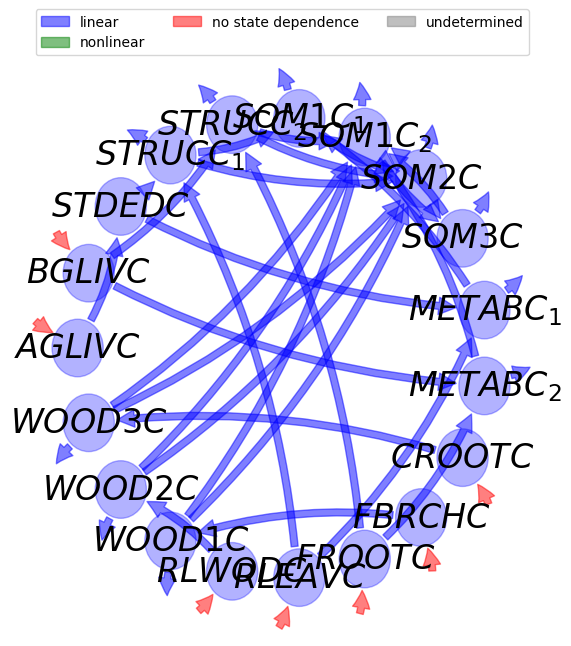

In [7]:
from bgc_md2.helper import compartmental_graph
compartmental_graph(mvs)

In [8]:
from bgc_md2.display_helpers import mass_balance_equation
mass_balance_equation(mvs)

<IPython.core.display.Math object>

In [9]:
##for comparison the century model as found in our database
#from bgc_md2.models.Parton1987SoilSciSocAmJ.source_by_name import mvs as mvs_century
#mvs.computable_mvar_types
#mvs_century.get_InputTuple()
#compartmental_graph(mvs_century)
#mass_balance_equation(mvs_century)
#BI=mvs_century.get_BibInfo()
#BI.sym_dict

In [10]:
# I will just create a dictionary with completely arbitrary values for the parameters
# and one for the functions 
# Don't get a heart attack .. how ignorant I might be about the TRUE values... 
# This is just a guide for the technical side

# first I find out which parameters there are...
# Any sympy expression has a free_symbols method and I implemented a similar one
# for the symbolic model class. Its a shortcut that looks at matrix and Inputs 
# and removes the statevariables automatically
srm=mvs.get_SmoothReservoirModel()
srm.free_symbols
# Of course you would probably know this but this little test is useful half way through 
# to check which parameters are still in need of a value...

{AGLIVC,
 BGLIVC,
 CROOTC,
 FBRCHC,
 FROOTC,
 METABC_1,
 METABC_2,
 RLEAVC,
 RLWODC,
 SOM1C_1,
 SOM1C_2,
 SOM2C,
 SOM3C,
 STDEDC,
 STRUCC_1,
 STRUCC_2,
 WOOD1C,
 WOOD2C,
 WOOD3C,
 arain,
 avh2o_1,
 avh2o_2,
 bglivc_1,
 bglive_1,
 biof,
 dec1_1,
 dec1_2,
 dec2_1,
 dec2_2,
 dec3_1,
 dec3_2,
 dec4,
 dec5,
 deck5,
 decw1,
 decw2,
 decw3,
 defac,
 dthppt,
 e,
 eftext,
 f_asmos2,
 f_lait_laitop,
 f_stemp_ppdf_1,
 f_stemp_ppdf_2,
 fallrt,
 fcfrac_1_1,
 fcfrac_2_1,
 fcfrac_3_1,
 fcfrac_4_1,
 fcfrac_5_1,
 fligni1_1,
 fligni1_2,
 fligni2_1,
 fligni2_2,
 fps1s3,
 fps2s3,
 frootc_1,
 froote_1,
 fsdeth_i,
 fsdeth_s,
 leafdr_d_mo,
 leafdr_e_mo,
 orglch,
 p1co2_2,
 pet,
 ppt_m,
 prdx_1,
 prdx_2,
 rdr,
 rleavc_1,
 rleave_1,
 rtsh,
 sdlng,
 shdmod,
 spl_I,
 spl_S,
 stdedc_1,
 stdede_1,
 strlig_1,
 strlig_2,
 sumrsp,
 wdlig_1,
 wdlig_2,
 wdlig_3,
 wdlig_4,
 wdlig_5,
 wooddr_1,
 wooddr_2,
 wooddr_3,
 wooddr_4,
 wooddr_5}

In [11]:
# In real live you would probably read this from a textfile
par_dict={
    AGLIVC:1,
    BGLIVC:1,
    CROOTC:1,
    FBRCHC:1,
    FROOTC:1,
    METABC_1:1,
    METABC_2:1,
    RLEAVC:1,
    RLWODC:1,
    SOM1C_1:1,
    SOM1C_2:1,
    SOM2C:1,
    SOM3C:1,
    STDEDC:1,
    STRUCC_1:1,
    STRUCC_2:1,
    WOOD1C:1,
    WOOD2C:1,
    WOOD3C:1,
    arain:1,
    avh2o_1:1,
    avh2o_2:1,
    bglivc_1:1,
    bglive_1:1,
    biof:1,
    dec1_1:1,
    dec1_2:1,
    dec2_1:1,
    dec2_2:1,
    dec3_1:1,
    dec3_2:1,
    dec4:1,
    dec5:1,
    deck5:1,
    decw1:1,
    decw2:1,
    decw3:1,
    defac:1,
    dthppt:1,
    e:1,
    eftext:1,
    f_asmos2:1,
    f_lait_laitop:1,
    f_stemp_ppdf_1:1,
    f_stemp_ppdf_2:1,
    fallrt:1,
    fcfrac_1_1:1,
    fcfrac_2_1:1,
    fcfrac_3_1:1,
    fcfrac_4_1:1,
    fcfrac_5_1:1,
    fligni1_1:1,
    fligni1_2:1,
    fligni2_1:1,
    fligni2_2:1,
    fps1s3:1,
    fps2s3:1,
    frootc_1:1,
    froote_1:1,
    fsdeth_i:1,
    fsdeth_s:1,
    leafdr_d_mo:1,
    leafdr_e_mo:1,
    orglch:1,
    p1co2_2:1,
    pet:1,
    ppt_m:1,
    prdx_1:1,
    prdx_2:1,
    rdr:1,
    rleavc_1:1,
    rleave_1:1,
    rtsh:1,
    sdlng:1,
    shdmod:1,
    spl_I:1,
    spl_S:1,
    stdedc_1:1,
    stdede_1:1,
    strlig_1:1,
    strlig_2:1,
    sumrsp:1,
    wdlig_1:1,
    wdlig_2:1,
    wdlig_3:1,
    wdlig_4:1,
    wdlig_5:1,
    wooddr_1:1,
    wooddr_2:1,
    wooddr_3:1,
    wooddr_4:1,
    wooddr_5:1,
}

In [12]:
# The functions are a bit more obvious since we only expressed a view of them explicitly 
# but we could also find them as the little example schows...
test_f = Function("test_f")
x = Symbol("x")
expr = x**2*test_f(x)
expr, expr.atoms(Function)

(x**2*test_f(x), {test_f(x)})

In [13]:
# Now for our real model, where functions could be in the  
mvs.get_InputTuple().atoms(Function).union(mvs.get_CompartmentalMatrix().atoms(Function))

set()

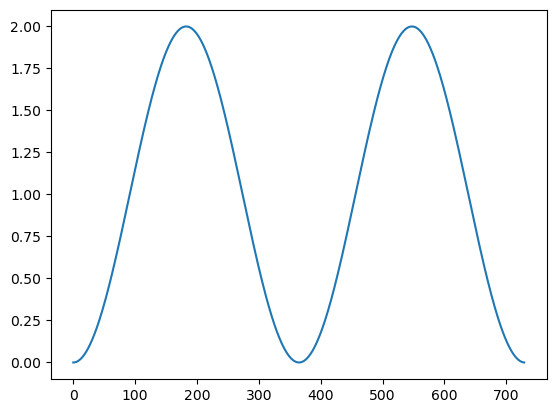

In [18]:
import numpy as np
import matplotlib.pyplot as plt
# It seems that the G_pp_grass function is no longer here 
# but I demonstrate how to build a concrete numeric version of this symbolic function,
# which will in real live in all likelyhood be an interpolation from data (probably from a netcdf file)
# We can build such a function later when you tell me about your data format.
# Here invented  a seasonal function with a peak in the middle of the year
def num_G_pp_grass(t):
    omega=2*np.pi/365 #period of 365 days  
    phi=np.pi # phaseshift to start at the lowest value at t=0
    return 1+np.cos(omega*t + phi)
ts=np.array(range(730))
ax=plt.plot(ts,num_G_pp_grass(ts))
#func_dict={Gpp_grass(t): num_G_pp_grass}
# but since we have not functions left we define an empty func_dict
func_dict=dict()

In [24]:
# The last thing we need to run the model are the startvalues
svd={
    AGLIVC:10, 
    BGLIVC:10, 
    STDEDC:1.1, 
    STRUCC_1:10, 
    STRUCC_2:10, 
    SOM1C_1:10,
    SOM1C_2:10,
    SOM2C:10,
    SOM3C:10,
    METABC_1:10,
    METABC_2:10,
    CROOTC:10,
    FBRCHC:10,
    FROOTC:10,
    RLEAVC:10,
    RLWODC:10,
    WOOD1C:10,
    WOOD2C:10,
    WOOD3C:10
}
svt=mvs.get_StateVariableTuple()
svt

Matrix([
[  AGLIVC],
[  BGLIVC],
[  STDEDC],
[STRUCC_1],
[STRUCC_2],
[ SOM1C_1],
[ SOM1C_2],
[   SOM2C],
[   SOM3C],
[METABC_1],
[METABC_2],
[  CROOTC],
[  FBRCHC],
[  FROOTC],
[  RLEAVC],
[  RLWODC],
[  WOOD1C],
[  WOOD2C],
[  WOOD3C]])

In [25]:
# We make a small test that we have all startvalues of them by substituting the values  for the symbols
svt.subs(svd)

Matrix([
[ 10],
[ 10],
[1.1],
[ 10],
[ 10],
[ 10],
[ 10],
[ 10],
[ 10],
[ 10],
[ 10],
[ 10],
[ 10],
[ 10],
[ 10],
[ 10],
[ 10],
[ 10],
[ 10]])

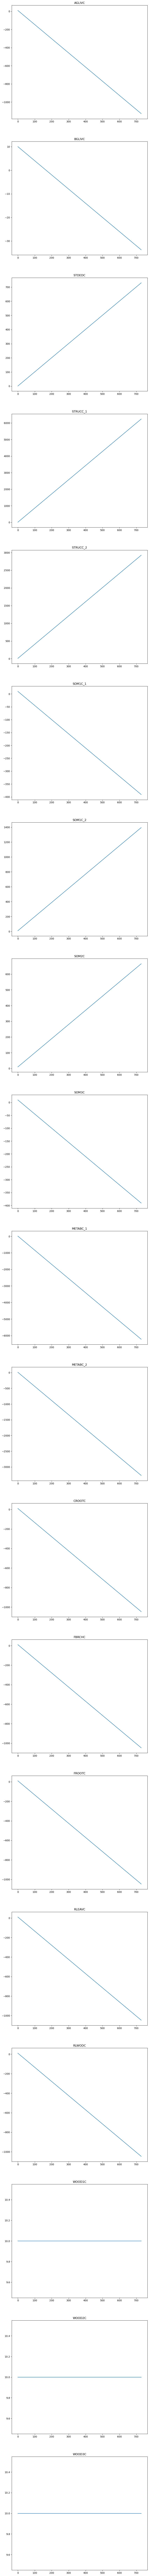

In [26]:
# Now we can update our mvs object (CMTVS Connected Multi Type Variable Set) 
from bgc_md2.resolve.mvars import NumericParameterization,NumericStartValueDict,NumericSimulationTimes
mvs=mvs.update(
    [
        NumericParameterization(par_dict=par_dict,func_dict=func_dict),
        NumericStartValueDict(svd),
        NumericSimulationTimes(ts)
    ]
)

sa=mvs.get_NumericSolutionArray()
_, n_pools=sa.shape
fig = plt.figure(figsize=(10,10*n_pools))
axs=fig.subplots(n_pools)
for i in range(n_pools):
    ax=axs[i]
    ax.plot(ts,sa[:,i])
    ax.set_title(svt[i])